# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenated = layers.concatenate([upsampled, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concatenated, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder_layer1 = encoder_block(inputs, 32, 2)
    encoder_layer2 = encoder_block(encoder_layer1, 64, 2)
    encoder_layer3 = encoder_block(encoder_layer2, 128, 2)
    #encoder_layer4 = encoder_block(encoder_layer3, 256, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_layer = conv2d_batchnorm(encoder_layer3, 512, 1, 1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    #decoder_layer4 = decoder_block(conv_layer, encoder_layer3, 256)
    decoder_layer3 = decoder_block(conv_layer, encoder_layer2, 128)
    decoder_layer2 = decoder_block(decoder_layer3, encoder_layer1, 64)
    decoder_layer1 = decoder_block(decoder_layer2, inputs, 32)
    
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_layer1)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.0001
batch_size = 100
num_epochs = 100
steps_per_epoch = 42
validation_steps = 12
workers = 2

Epoch 1/100
41/42 [============================>.] - ETA: 1s - loss: 1.2319

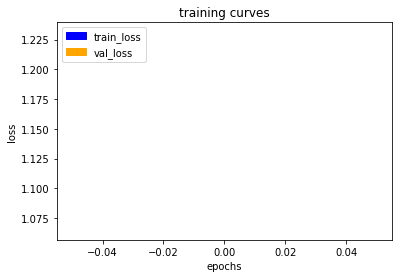

42/42 [==============================] - 65s - loss: 1.2295 - val_loss: 1.0652
Epoch 2/100
41/42 [============================>.] - ETA: 1s - loss: 1.0935

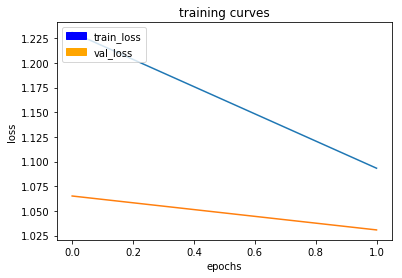

42/42 [==============================] - 60s - loss: 1.0929 - val_loss: 1.0308
Epoch 3/100
41/42 [============================>.] - ETA: 1s - loss: 1.0474

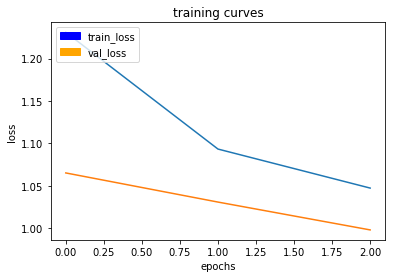

42/42 [==============================] - 61s - loss: 1.0470 - val_loss: 0.9979
Epoch 4/100
41/42 [============================>.] - ETA: 1s - loss: 1.0119

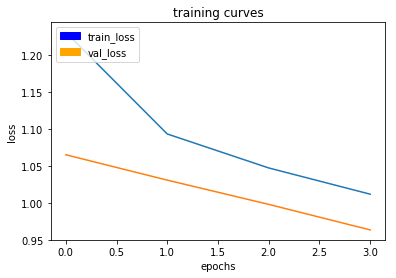

42/42 [==============================] - 60s - loss: 1.0115 - val_loss: 0.9633
Epoch 5/100
41/42 [============================>.] - ETA: 1s - loss: 0.9788

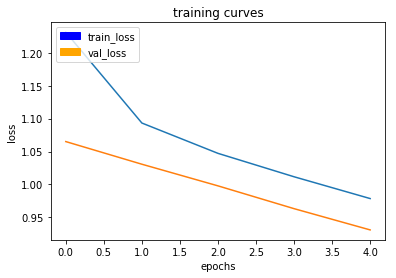

42/42 [==============================] - 61s - loss: 0.9784 - val_loss: 0.9310
Epoch 6/100
41/42 [============================>.] - ETA: 1s - loss: 0.9457

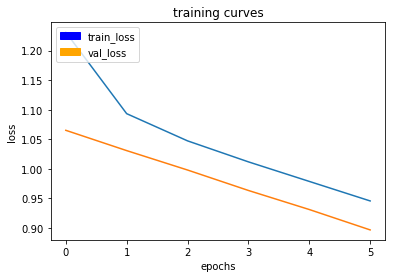

42/42 [==============================] - 60s - loss: 0.9454 - val_loss: 0.8965
Epoch 7/100
41/42 [============================>.] - ETA: 1s - loss: 0.9112

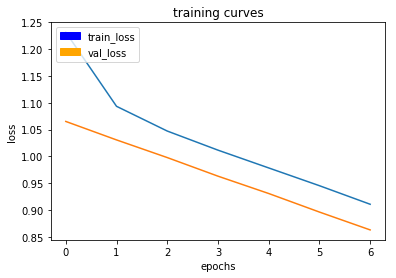

42/42 [==============================] - 60s - loss: 0.9107 - val_loss: 0.8633
Epoch 8/100
41/42 [============================>.] - ETA: 1s - loss: 0.8737

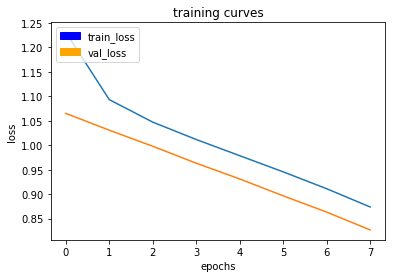

42/42 [==============================] - 60s - loss: 0.8736 - val_loss: 0.8268
Epoch 9/100
41/42 [============================>.] - ETA: 1s - loss: 0.8321

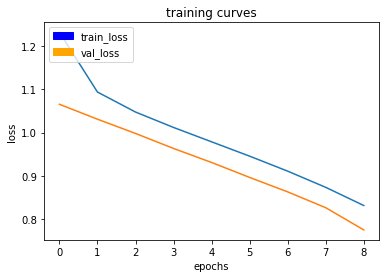

42/42 [==============================] - 61s - loss: 0.8312 - val_loss: 0.7756
Epoch 10/100
41/42 [============================>.] - ETA: 1s - loss: 0.7819

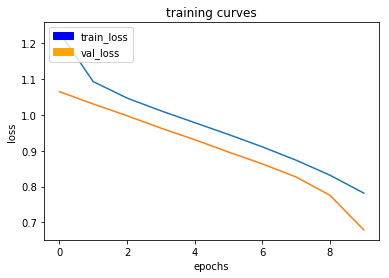

42/42 [==============================] - 61s - loss: 0.7820 - val_loss: 0.6790
Epoch 11/100
41/42 [============================>.] - ETA: 1s - loss: 0.7271

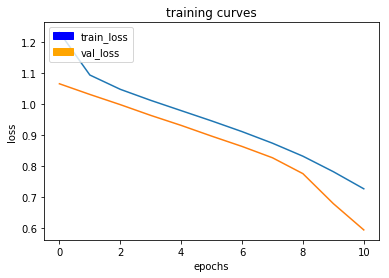

42/42 [==============================] - 61s - loss: 0.7262 - val_loss: 0.5943
Epoch 12/100
41/42 [============================>.] - ETA: 1s - loss: 0.6774

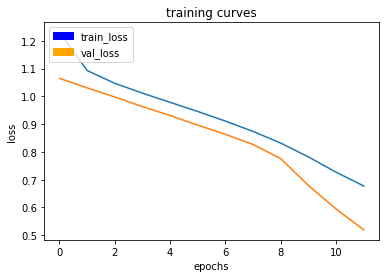

42/42 [==============================] - 61s - loss: 0.6769 - val_loss: 0.5189
Epoch 13/100
41/42 [============================>.] - ETA: 1s - loss: 0.6333

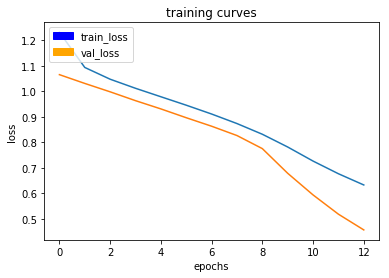

42/42 [==============================] - 61s - loss: 0.6333 - val_loss: 0.4573
Epoch 14/100
41/42 [============================>.] - ETA: 1s - loss: 0.5931

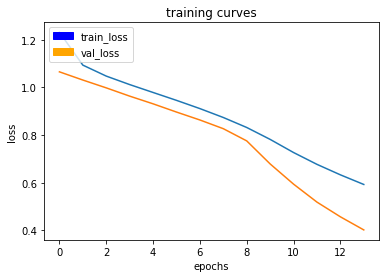

42/42 [==============================] - 61s - loss: 0.5924 - val_loss: 0.4023
Epoch 15/100
41/42 [============================>.] - ETA: 1s - loss: 0.5546

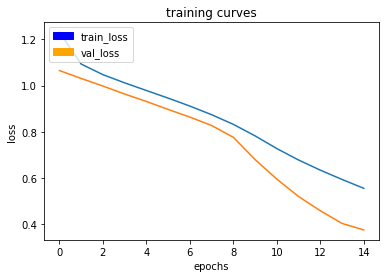

42/42 [==============================] - 60s - loss: 0.5544 - val_loss: 0.3742
Epoch 16/100
41/42 [============================>.] - ETA: 1s - loss: 0.5188

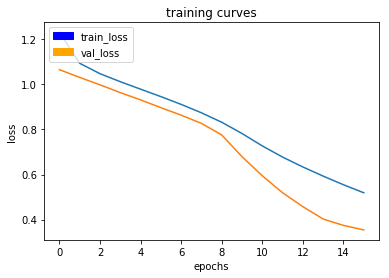

42/42 [==============================] - 60s - loss: 0.5194 - val_loss: 0.3542
Epoch 17/100
41/42 [============================>.] - ETA: 1s - loss: 0.4866

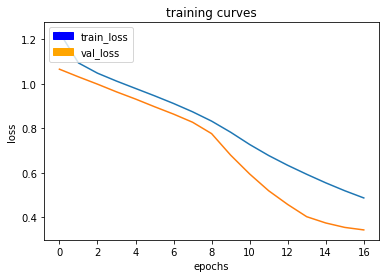

42/42 [==============================] - 61s - loss: 0.4867 - val_loss: 0.3430
Epoch 18/100
41/42 [============================>.] - ETA: 1s - loss: 0.4558

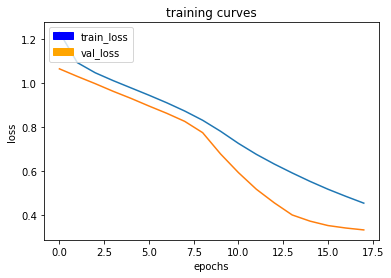

42/42 [==============================] - 61s - loss: 0.4557 - val_loss: 0.3344
Epoch 19/100
41/42 [============================>.] - ETA: 1s - loss: 0.4267

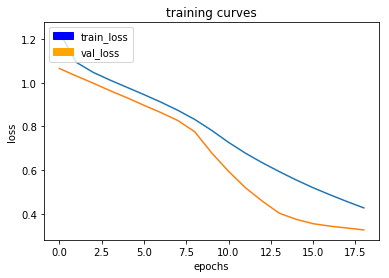

42/42 [==============================] - 61s - loss: 0.4264 - val_loss: 0.3257
Epoch 20/100
41/42 [============================>.] - ETA: 1s - loss: 0.4005

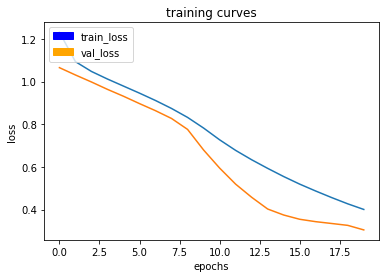

42/42 [==============================] - 61s - loss: 0.3999 - val_loss: 0.3043
Epoch 21/100
41/42 [============================>.] - ETA: 1s - loss: 0.3739

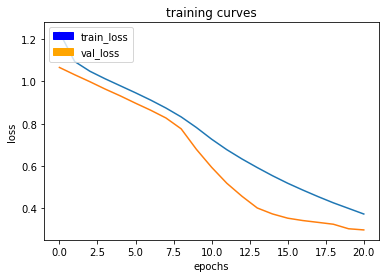

42/42 [==============================] - 60s - loss: 0.3738 - val_loss: 0.2989
Epoch 22/100
41/42 [============================>.] - ETA: 1s - loss: 0.3504

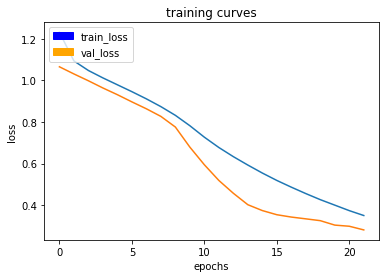

42/42 [==============================] - 60s - loss: 0.3504 - val_loss: 0.2812
Epoch 23/100
41/42 [============================>.] - ETA: 1s - loss: 0.3291

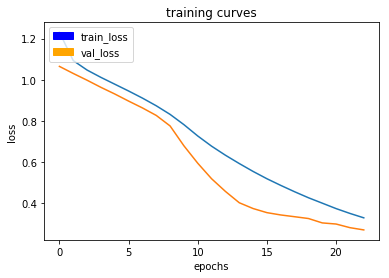

42/42 [==============================] - 61s - loss: 0.3289 - val_loss: 0.2703
Epoch 24/100
41/42 [============================>.] - ETA: 1s - loss: 0.3084

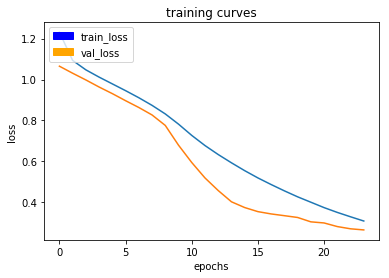

42/42 [==============================] - 60s - loss: 0.3083 - val_loss: 0.2648
Epoch 25/100
41/42 [============================>.] - ETA: 1s - loss: 0.2888

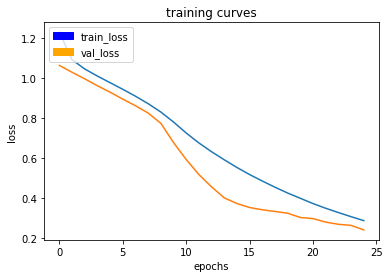

42/42 [==============================] - 60s - loss: 0.2885 - val_loss: 0.2422
Epoch 26/100
41/42 [============================>.] - ETA: 1s - loss: 0.2713

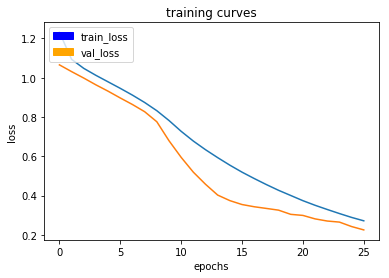

42/42 [==============================] - 61s - loss: 0.2713 - val_loss: 0.2250
Epoch 27/100
41/42 [============================>.] - ETA: 1s - loss: 0.2551

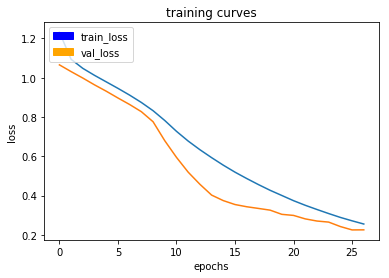

42/42 [==============================] - 61s - loss: 0.2549 - val_loss: 0.2254
Epoch 28/100
41/42 [============================>.] - ETA: 1s - loss: 0.2396

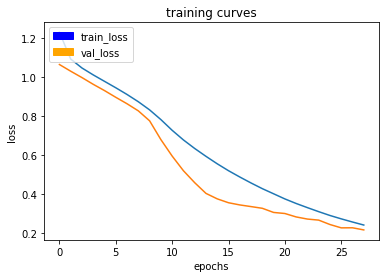

42/42 [==============================] - 60s - loss: 0.2394 - val_loss: 0.2144
Epoch 29/100
41/42 [============================>.] - ETA: 1s - loss: 0.2259

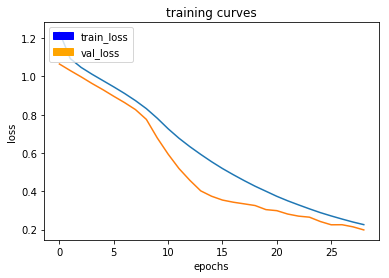

42/42 [==============================] - 61s - loss: 0.2256 - val_loss: 0.1982
Epoch 30/100
41/42 [============================>.] - ETA: 1s - loss: 0.2129

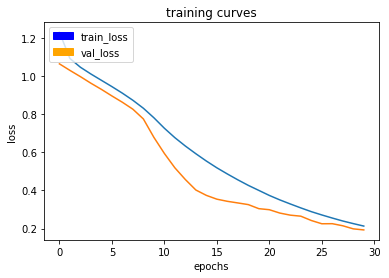

42/42 [==============================] - 60s - loss: 0.2128 - val_loss: 0.1927
Epoch 31/100
41/42 [============================>.] - ETA: 1s - loss: 0.2007

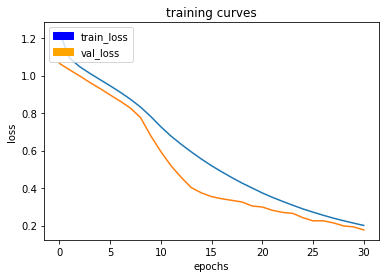

42/42 [==============================] - 60s - loss: 0.2006 - val_loss: 0.1767
Epoch 32/100
41/42 [============================>.] - ETA: 1s - loss: 0.1901

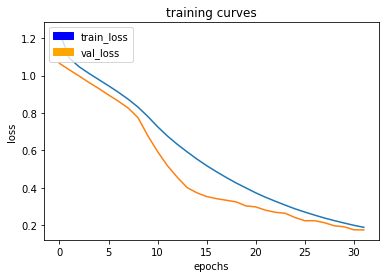

42/42 [==============================] - 61s - loss: 0.1897 - val_loss: 0.1761
Epoch 33/100
41/42 [============================>.] - ETA: 1s - loss: 0.1795

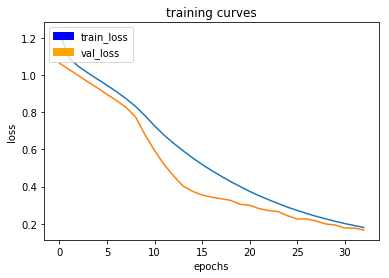

42/42 [==============================] - 61s - loss: 0.1794 - val_loss: 0.1664
Epoch 34/100
41/42 [============================>.] - ETA: 1s - loss: 0.1701

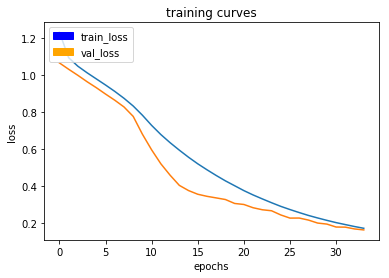

42/42 [==============================] - 60s - loss: 0.1698 - val_loss: 0.1611
Epoch 35/100
41/42 [============================>.] - ETA: 1s - loss: 0.1614

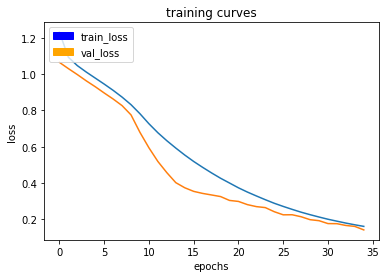

42/42 [==============================] - 60s - loss: 0.1612 - val_loss: 0.1418
Epoch 36/100
41/42 [============================>.] - ETA: 1s - loss: 0.1528

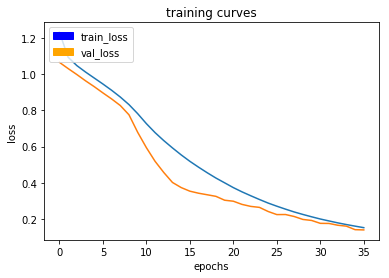

42/42 [==============================] - 60s - loss: 0.1530 - val_loss: 0.1405
Epoch 37/100
41/42 [============================>.] - ETA: 1s - loss: 0.1456

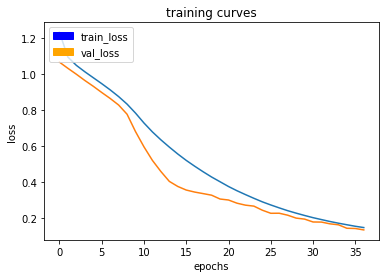

42/42 [==============================] - 61s - loss: 0.1458 - val_loss: 0.1326
Epoch 38/100
41/42 [============================>.] - ETA: 1s - loss: 0.1388

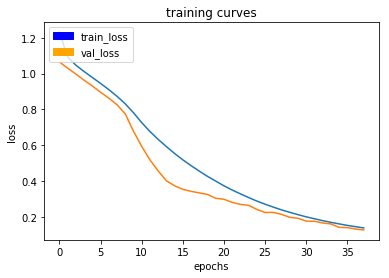

42/42 [==============================] - 60s - loss: 0.1387 - val_loss: 0.1277
Epoch 39/100
41/42 [============================>.] - ETA: 1s - loss: 0.1324

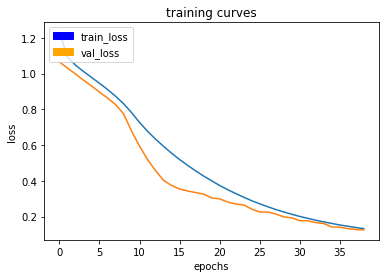

42/42 [==============================] - 61s - loss: 0.1324 - val_loss: 0.1252
Epoch 40/100
41/42 [============================>.] - ETA: 1s - loss: 0.1263

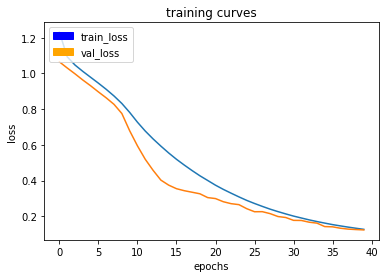

42/42 [==============================] - 60s - loss: 0.1262 - val_loss: 0.1231
Epoch 41/100
41/42 [============================>.] - ETA: 1s - loss: 0.1211

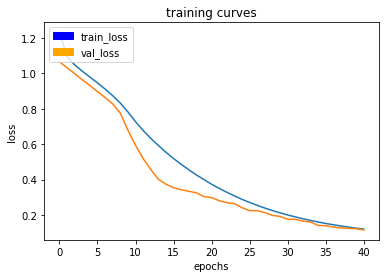

42/42 [==============================] - 61s - loss: 0.1211 - val_loss: 0.1165
Epoch 42/100
41/42 [============================>.] - ETA: 1s - loss: 0.1159

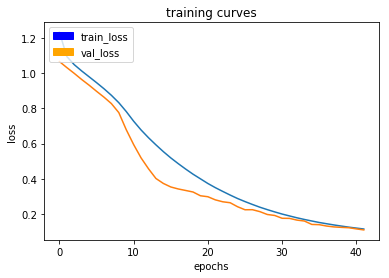

42/42 [==============================] - 60s - loss: 0.1160 - val_loss: 0.1108
Epoch 43/100
41/42 [============================>.] - ETA: 1s - loss: 0.1109

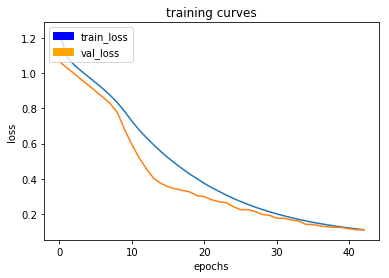

42/42 [==============================] - 61s - loss: 0.1108 - val_loss: 0.1101
Epoch 44/100
41/42 [============================>.] - ETA: 1s - loss: 0.1069

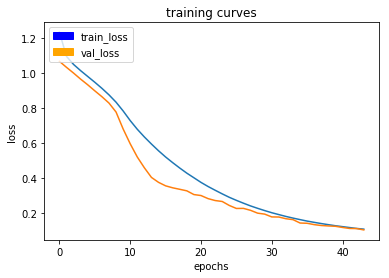

42/42 [==============================] - 60s - loss: 0.1070 - val_loss: 0.1025
Epoch 45/100
41/42 [============================>.] - ETA: 1s - loss: 0.1026

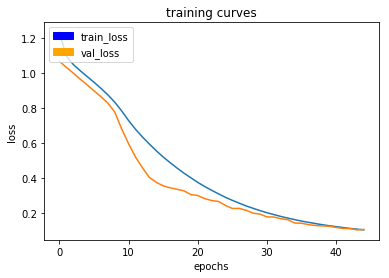

42/42 [==============================] - 61s - loss: 0.1028 - val_loss: 0.1051
Epoch 46/100
41/42 [============================>.] - ETA: 1s - loss: 0.0988

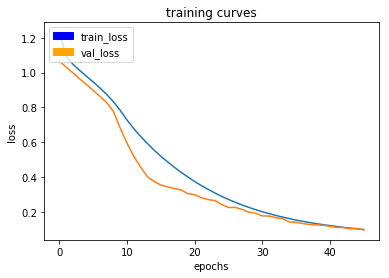

42/42 [==============================] - 60s - loss: 0.0987 - val_loss: 0.0965
Epoch 47/100
41/42 [============================>.] - ETA: 1s - loss: 0.0947

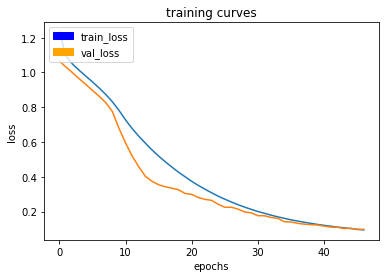

42/42 [==============================] - 61s - loss: 0.0949 - val_loss: 0.0985
Epoch 48/100
41/42 [============================>.] - ETA: 1s - loss: 0.0919

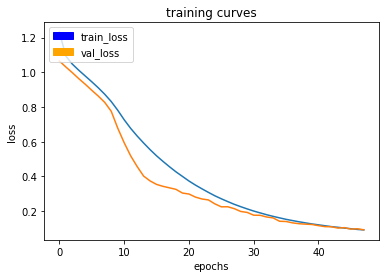

42/42 [==============================] - 61s - loss: 0.0919 - val_loss: 0.0927
Epoch 49/100
41/42 [============================>.] - ETA: 1s - loss: 0.0884

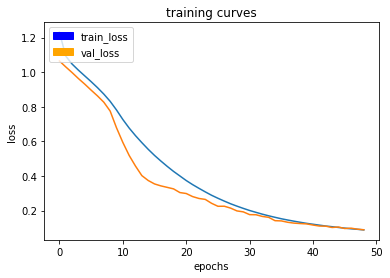

42/42 [==============================] - 61s - loss: 0.0884 - val_loss: 0.0893
Epoch 50/100
41/42 [============================>.] - ETA: 1s - loss: 0.0854

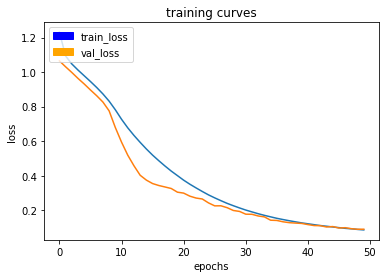

42/42 [==============================] - 60s - loss: 0.0859 - val_loss: 0.0897
Epoch 51/100
41/42 [============================>.] - ETA: 1s - loss: 0.0826

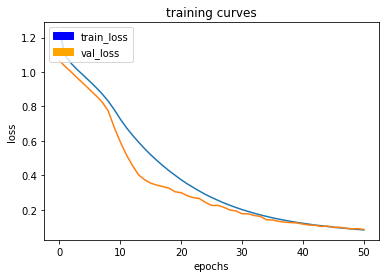

42/42 [==============================] - 60s - loss: 0.0827 - val_loss: 0.0857
Epoch 52/100
41/42 [============================>.] - ETA: 1s - loss: 0.0801

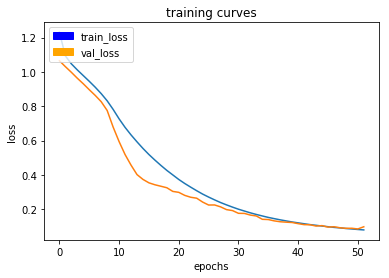

42/42 [==============================] - 60s - loss: 0.0801 - val_loss: 0.0984
Epoch 53/100
41/42 [============================>.] - ETA: 1s - loss: 0.0777

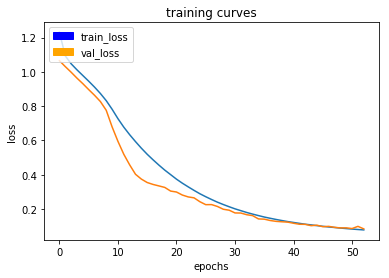

42/42 [==============================] - 60s - loss: 0.0776 - val_loss: 0.0837
Epoch 54/100
41/42 [============================>.] - ETA: 1s - loss: 0.0755

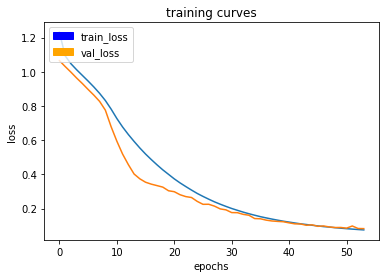

42/42 [==============================] - 61s - loss: 0.0752 - val_loss: 0.0829
Epoch 55/100
41/42 [============================>.] - ETA: 1s - loss: 0.0735

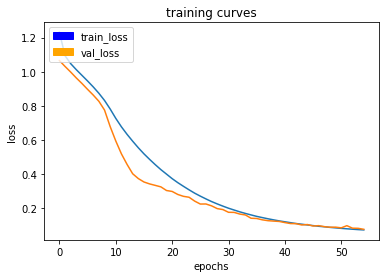

42/42 [==============================] - 61s - loss: 0.0735 - val_loss: 0.0770
Epoch 56/100
41/42 [============================>.] - ETA: 1s - loss: 0.0709

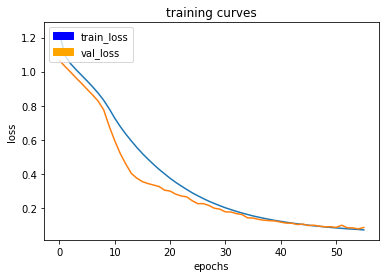

42/42 [==============================] - 60s - loss: 0.0709 - val_loss: 0.0849
Epoch 57/100
41/42 [============================>.] - ETA: 1s - loss: 0.0698

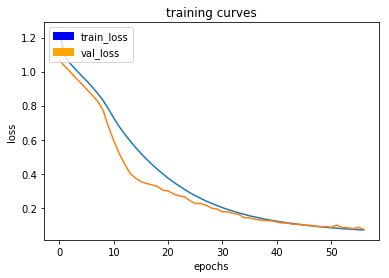

42/42 [==============================] - 60s - loss: 0.0704 - val_loss: 0.0734
Epoch 58/100
41/42 [============================>.] - ETA: 1s - loss: 0.0676

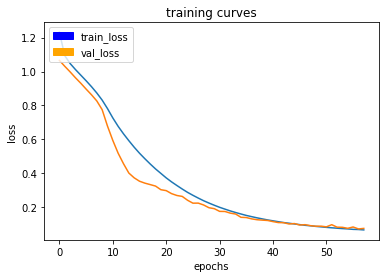

42/42 [==============================] - 60s - loss: 0.0676 - val_loss: 0.0765
Epoch 59/100
41/42 [============================>.] - ETA: 1s - loss: 0.0651

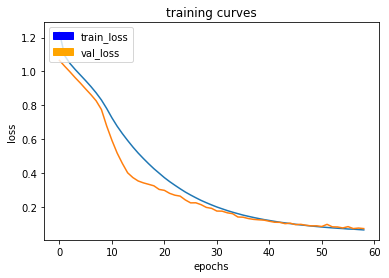

42/42 [==============================] - 61s - loss: 0.0665 - val_loss: 0.0734
Epoch 60/100
41/42 [============================>.] - ETA: 1s - loss: 0.0639

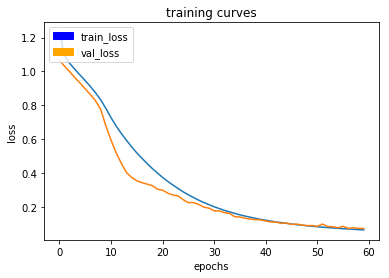

42/42 [==============================] - 61s - loss: 0.0642 - val_loss: 0.0723
Epoch 61/100
41/42 [============================>.] - ETA: 1s - loss: 0.0627

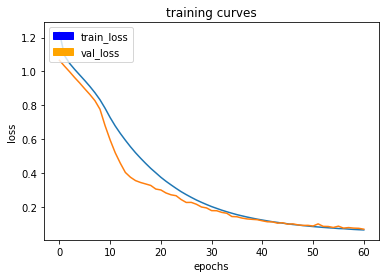

42/42 [==============================] - 60s - loss: 0.0627 - val_loss: 0.0670
Epoch 62/100
41/42 [============================>.] - ETA: 1s - loss: 0.0608

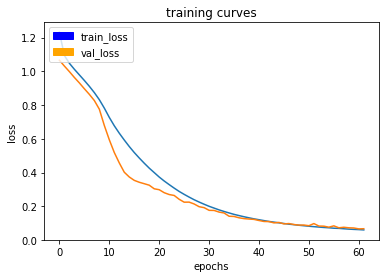

42/42 [==============================] - 61s - loss: 0.0608 - val_loss: 0.0679
Epoch 63/100
41/42 [============================>.] - ETA: 1s - loss: 0.0597

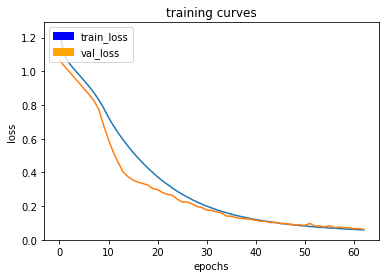

42/42 [==============================] - 61s - loss: 0.0594 - val_loss: 0.0626
Epoch 64/100
41/42 [============================>.] - ETA: 1s - loss: 0.0580

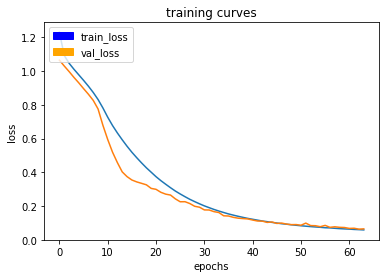

42/42 [==============================] - 61s - loss: 0.0580 - val_loss: 0.0643
Epoch 65/100
41/42 [============================>.] - ETA: 1s - loss: 0.0564

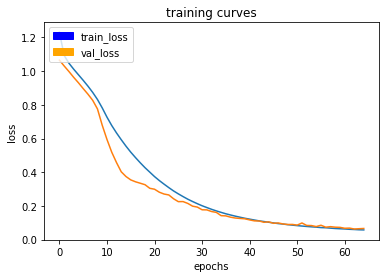

42/42 [==============================] - 61s - loss: 0.0587 - val_loss: 0.0657
Epoch 66/100
41/42 [============================>.] - ETA: 1s - loss: 0.0561

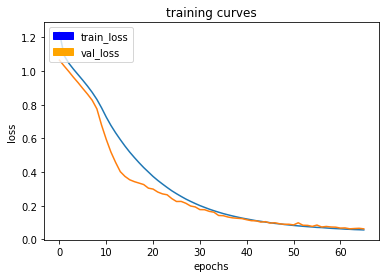

42/42 [==============================] - 61s - loss: 0.0559 - val_loss: 0.0624
Epoch 67/100
41/42 [============================>.] - ETA: 1s - loss: 0.0547

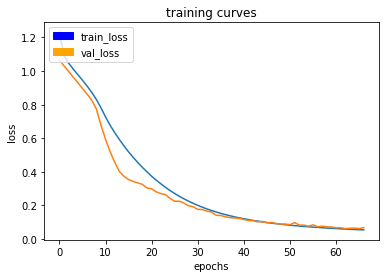

42/42 [==============================] - 61s - loss: 0.0545 - val_loss: 0.0680
Epoch 68/100
41/42 [============================>.] - ETA: 1s - loss: 0.0533

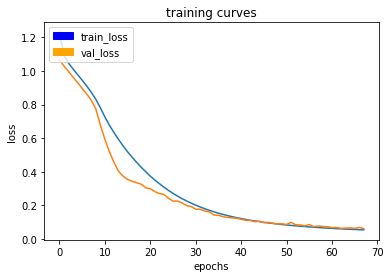

42/42 [==============================] - 61s - loss: 0.0533 - val_loss: 0.0611
Epoch 69/100
41/42 [============================>.] - ETA: 1s - loss: 0.0527

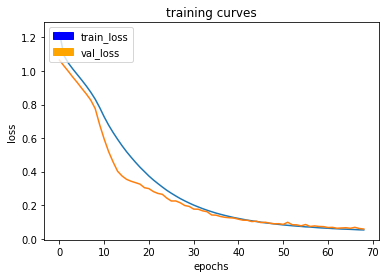

42/42 [==============================] - 61s - loss: 0.0526 - val_loss: 0.0580
Epoch 70/100
41/42 [============================>.] - ETA: 1s - loss: 0.0514

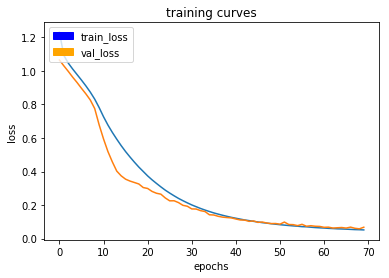

42/42 [==============================] - 60s - loss: 0.0517 - val_loss: 0.0675
Epoch 71/100
41/42 [============================>.] - ETA: 1s - loss: 0.0508

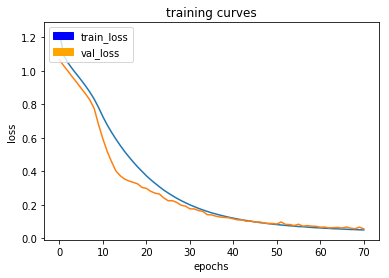

42/42 [==============================] - 61s - loss: 0.0507 - val_loss: 0.0568
Epoch 72/100
41/42 [============================>.] - ETA: 1s - loss: 0.0497

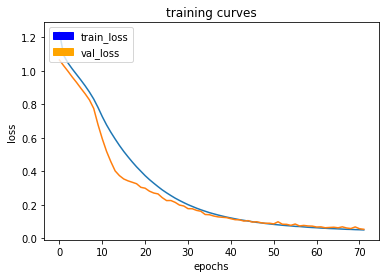

42/42 [==============================] - 60s - loss: 0.0497 - val_loss: 0.0534
Epoch 73/100
41/42 [============================>.] - ETA: 1s - loss: 0.0486

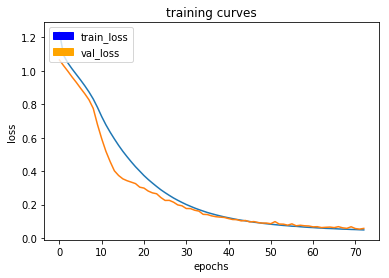

42/42 [==============================] - 61s - loss: 0.0486 - val_loss: 0.0577
Epoch 74/100
41/42 [============================>.] - ETA: 1s - loss: 0.0476

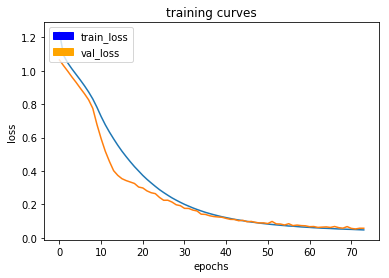

42/42 [==============================] - 61s - loss: 0.0476 - val_loss: 0.0575
Epoch 75/100
41/42 [============================>.] - ETA: 1s - loss: 0.0473

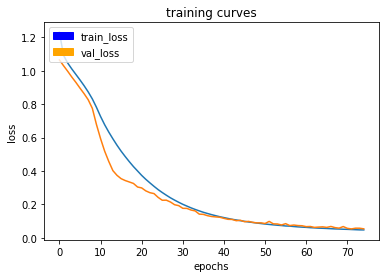

42/42 [==============================] - 60s - loss: 0.0473 - val_loss: 0.0539
Epoch 76/100
41/42 [============================>.] - ETA: 1s - loss: 0.0463

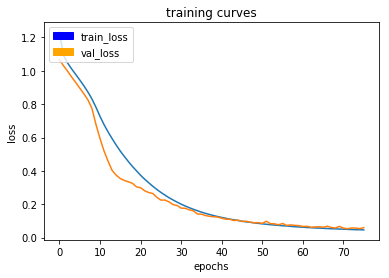

42/42 [==============================] - 60s - loss: 0.0463 - val_loss: 0.0597
Epoch 77/100
41/42 [============================>.] - ETA: 1s - loss: 0.0455

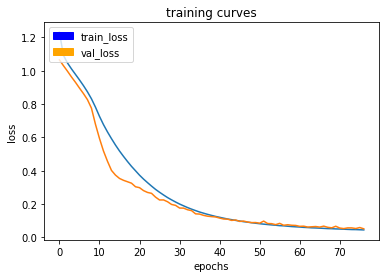

42/42 [==============================] - 61s - loss: 0.0453 - val_loss: 0.0521
Epoch 78/100
41/42 [============================>.] - ETA: 1s - loss: 0.0452

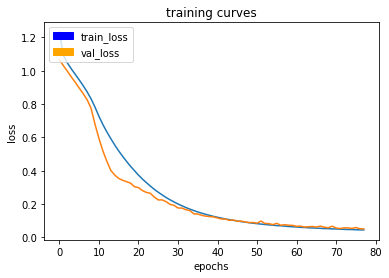

42/42 [==============================] - 61s - loss: 0.0453 - val_loss: 0.0513
Epoch 79/100
41/42 [============================>.] - ETA: 1s - loss: 0.0447

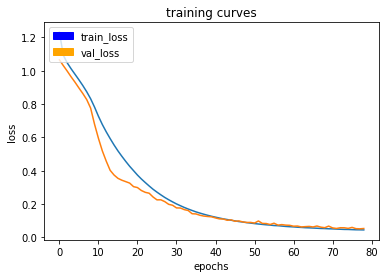

42/42 [==============================] - 61s - loss: 0.0445 - val_loss: 0.0531
Epoch 80/100
41/42 [============================>.] - ETA: 1s - loss: 0.0432

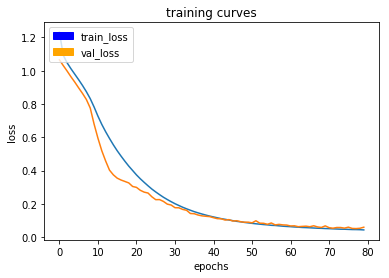

42/42 [==============================] - 61s - loss: 0.0431 - val_loss: 0.0594
Epoch 81/100
41/42 [============================>.] - ETA: 1s - loss: 0.0427

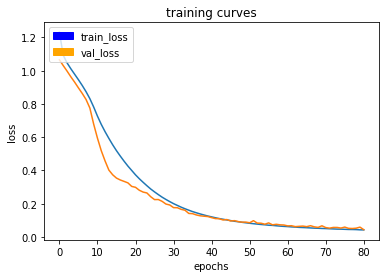

42/42 [==============================] - 60s - loss: 0.0427 - val_loss: 0.0441
Epoch 82/100
41/42 [============================>.] - ETA: 1s - loss: 0.0423

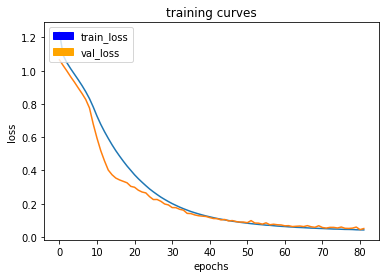

42/42 [==============================] - 61s - loss: 0.0423 - val_loss: 0.0506
Epoch 83/100
41/42 [============================>.] - ETA: 1s - loss: 0.0418

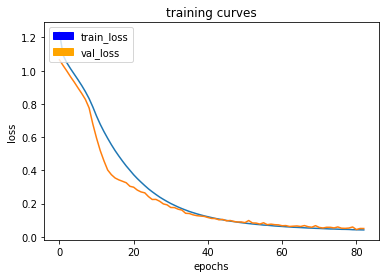

42/42 [==============================] - 61s - loss: 0.0418 - val_loss: 0.0502
Epoch 84/100
41/42 [============================>.] - ETA: 1s - loss: 0.0409

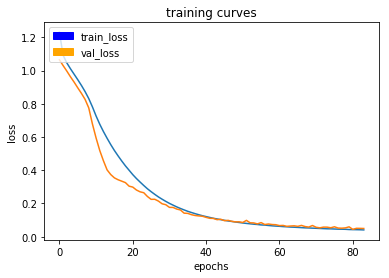

42/42 [==============================] - 62s - loss: 0.0409 - val_loss: 0.0495
Epoch 85/100
41/42 [============================>.] - ETA: 1s - loss: 0.0403

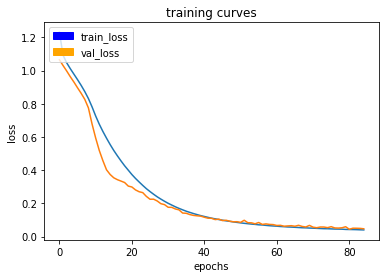

42/42 [==============================] - 60s - loss: 0.0401 - val_loss: 0.0471
Epoch 86/100
41/42 [============================>.] - ETA: 1s - loss: 0.0398

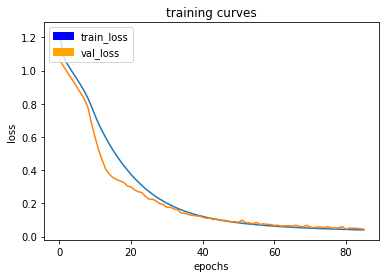

42/42 [==============================] - 60s - loss: 0.0398 - val_loss: 0.0444
Epoch 87/100
41/42 [============================>.] - ETA: 1s - loss: 0.0395

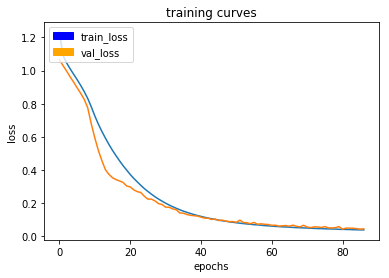

42/42 [==============================] - 61s - loss: 0.0395 - val_loss: 0.0461
Epoch 88/100
41/42 [============================>.] - ETA: 1s - loss: 0.0387

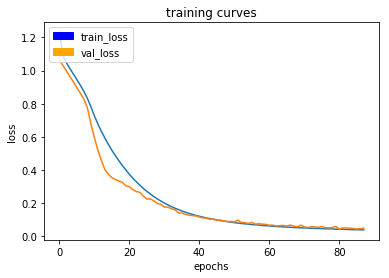

42/42 [==============================] - 61s - loss: 0.0387 - val_loss: 0.0497
Epoch 89/100
41/42 [============================>.] - ETA: 1s - loss: 0.0381

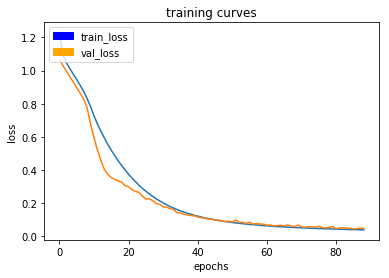

42/42 [==============================] - 60s - loss: 0.0380 - val_loss: 0.0474
Epoch 90/100
41/42 [============================>.] - ETA: 1s - loss: 0.0380

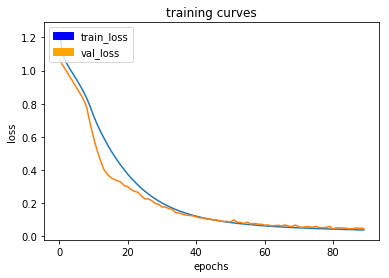

42/42 [==============================] - 60s - loss: 0.0379 - val_loss: 0.0465
Epoch 91/100
41/42 [============================>.] - ETA: 1s - loss: 0.0372

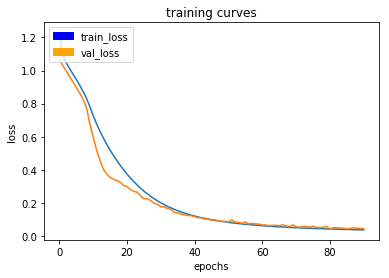

42/42 [==============================] - 62s - loss: 0.0374 - val_loss: 0.0450
Epoch 92/100
41/42 [============================>.] - ETA: 1s - loss: 0.0366

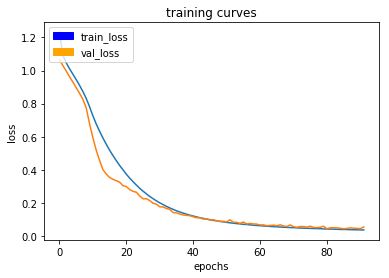

42/42 [==============================] - 61s - loss: 0.0384 - val_loss: 0.0553
Epoch 93/100
41/42 [============================>.] - ETA: 1s - loss: 0.0371

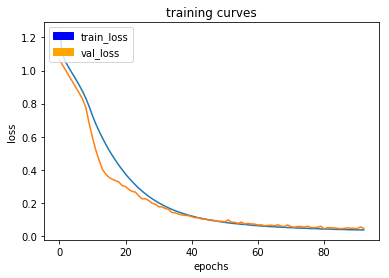

42/42 [==============================] - 60s - loss: 0.0371 - val_loss: 0.0453
Epoch 94/100
41/42 [============================>.] - ETA: 1s - loss: 0.0361

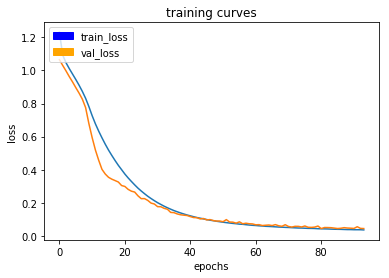

42/42 [==============================] - 60s - loss: 0.0360 - val_loss: 0.0443
Epoch 95/100
41/42 [============================>.] - ETA: 1s - loss: 0.0358

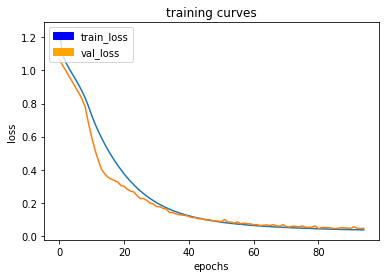

42/42 [==============================] - 61s - loss: 0.0357 - val_loss: 0.0459
Epoch 96/100
41/42 [============================>.] - ETA: 1s - loss: 0.0351

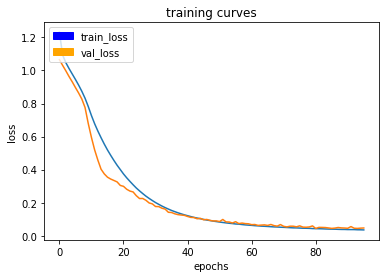

42/42 [==============================] - 61s - loss: 0.0351 - val_loss: 0.0468
Epoch 97/100
41/42 [============================>.] - ETA: 1s - loss: 0.0349

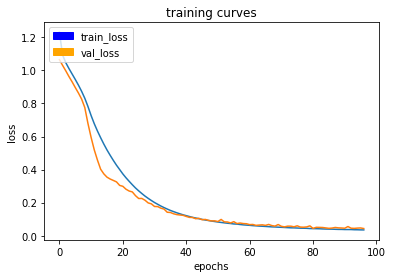

42/42 [==============================] - 61s - loss: 0.0349 - val_loss: 0.0433
Epoch 98/100
41/42 [============================>.] - ETA: 1s - loss: 0.0343

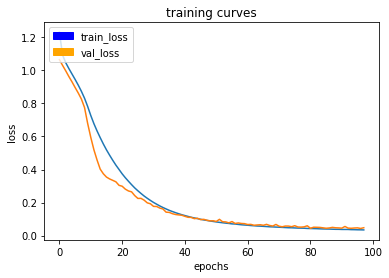

42/42 [==============================] - 60s - loss: 0.0344 - val_loss: 0.0476
Epoch 99/100
41/42 [============================>.] - ETA: 1s - loss: 0.0341

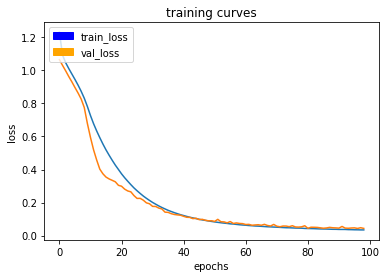

42/42 [==============================] - 61s - loss: 0.0345 - val_loss: 0.0434
Epoch 100/100
41/42 [============================>.] - ETA: 1s - loss: 0.0338

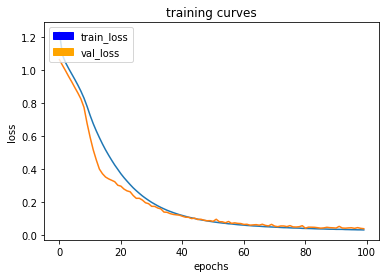

42/42 [==============================] - 60s - loss: 0.0337 - val_loss: 0.0412


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)
model.summary()

#keras.plot_model(model, to_file='model.png')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
separable_conv2d_keras_1 (Se (None, 80, 80, 32)        155       
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 32)        128       
_________________________________________________________________
separable_conv2d_keras_2 (Se (None, 40, 40, 64)        2400      
_________________________________________________________________
batch_normalization_2 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
separable_conv2d_keras_3 (Se (None, 20, 20, 128)       8896      
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 20, 128)       512       
__________

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights'
restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

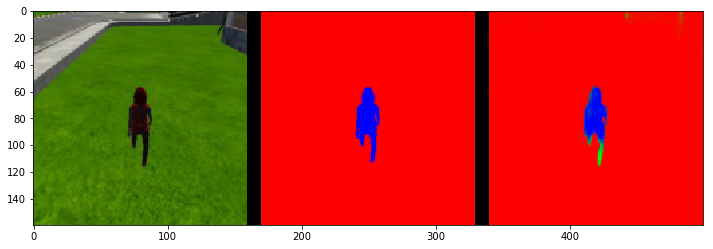

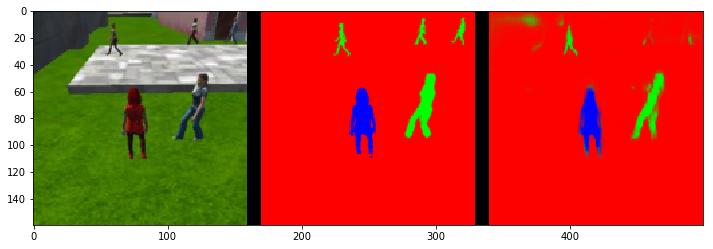

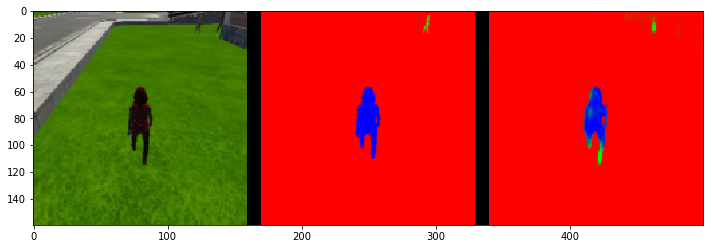

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

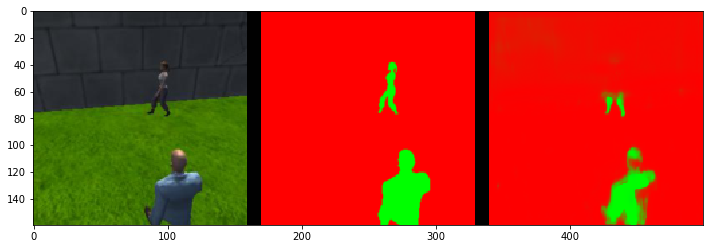

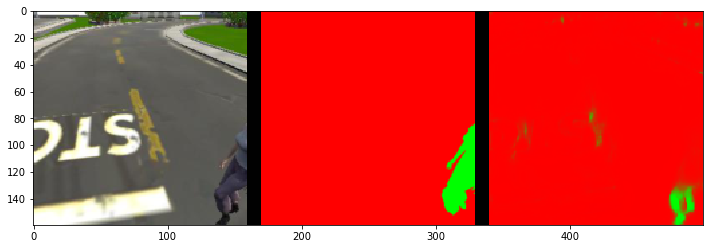

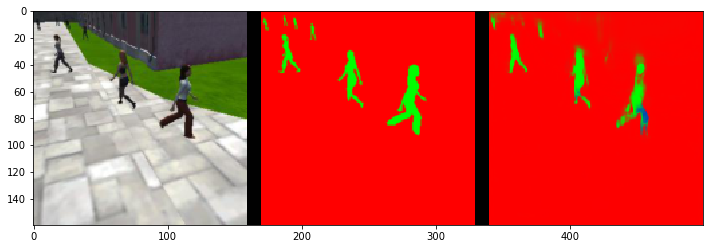

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

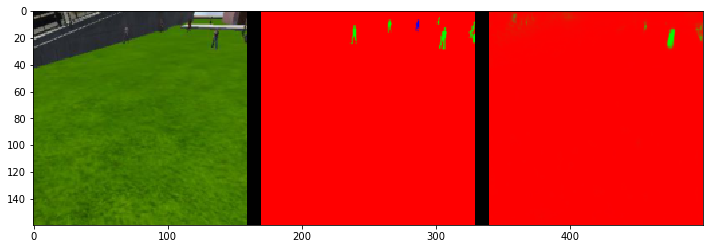

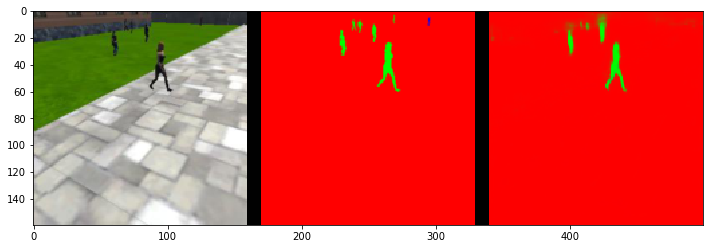

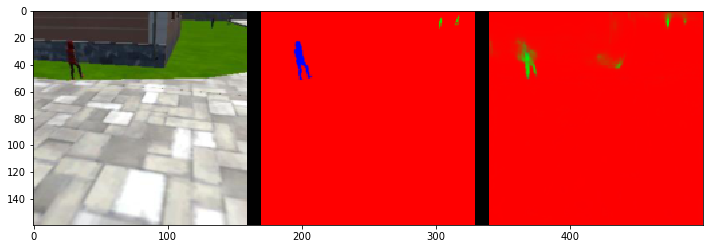

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9923988892624694
average intersection over union for other people is 0.22423518933546988
average intersection over union for the hero is 0.8127262269253246
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9798902501025913
average intersection over union for other people is 0.585850518951725
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 73, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.994081679547832
average intersection over union for other people is 0.3021039056782415
average intersection over union for the hero is 0.07613251886253057
number true positives: 66, number false positives: 2, number false negatives: 235


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.6612021857923497


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.444429372894


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.293857672788
